# Ackland-Thetford Finnis-Sinclair BCC Generator

This Notebook generates LAMMPS-compatible potential files for 1984 Finnis-Sinclair and 1987 Ackland-Thetford models for body-centered cubic elements.

In [1]:
from copy import deepcopy

import numpy as np

from potentials.paramfile import EAMFS

import matplotlib.pyplot as plt

## 1. Define function forms

This section defines the functional forms used by the potential.  Each of the three function categories takes the form 

    function(input, **kwargs)
    
where input is either rho or r, and kwargs are any function parameters not explicitly set by the function definition.  Functions for different interactions can be defined either

- as completely separate functions, or
- by defining a functional form and specifying the interaction-dependent parameters using kwargs.

### $F(\bar{\rho})$ function(s)

The embedding energy function is of the form

$$ F(\bar{\rho}) = - \sqrt{\bar{\rho}}$$

In [2]:
def F(rho, **kwargs):
    """F(rho) function for ATFS potentials"""
    return -rho**0.5

### $\rho(r)$ function(s)

The embedding density function is

$$ \rho(r) = A^2 (d - r)^2 + \frac{\beta (r - d)^3}{d}$$

for $r \le d$ and $\rho(r) = 0$ for $r > d$.

In [3]:
def rho(r, **kwargs):
    """rho(r) function for ATFS potentials"""
    
    #Define the function
    def rhofunc(r, A, d, beta):
        return A**2 * (d - r)**2 + beta * (r - d)**3 / d
    
    #Extract the parameters
    A = kwargs['A']
    d = kwargs['d']
    beta = kwargs['beta']
    
    #Return the values (with heaviside applied)
    return np.piecewise(r, [r <= d, r > d], [rhofunc, 0], A, d, beta)

### $\phi(r)$ function(s)

The pair function for the original Finnis-Sinclair bcc model is

$$ \phi_{FS}(r) = (r - c)^2 (c_0 + c_1 r + c_2 r^2)$$

for $r \le c$ and $\phi(r) = 0$ for $r > c$.

The Ackland-Thetford model adds an extra term

$$ \phi_{ATFS}(r) = \phi_{FS}(r) + \phi_{AT}(r) $$

where

$$ \phi_{AT}(r) = B (a_0 - r)^3 e^{-\alpha r} $$

for $r \le a_0$ and $\phi_{AT}(r) = 0$ for $r > a_0$.



In [4]:
def phi(r, **kwargs):
    """phi(r) function for ATFS potentials"""
    
    #Define the functions
    def phiFSfunc(r, c, c0, c1, c2):
        return (r - c)**2 * (c0 + c1 * r + c2 * r * r)
    def phiATfunc(r, B, a0, alpha):
        return B * (a0 - r)**3 * np.exp(-alpha * r)
    
    #Extract the parameters
    c = kwargs['c']
    c0 = kwargs['c0']
    c1 = kwargs['c1']
    c2 = kwargs['c2']
    B = kwargs['B']
    a0 = kwargs['a0']
    alpha = kwargs['alpha']
    
    #Return the values (with heaviside applied)
    return np.piecewise(r, [r <= c, r > c], [phiFSfunc, 0], c, c0, c1, c2) + np.piecewise(r, [r <= a0, r > a0], [phiATfunc, 0], B, a0, alpha)


### $r*\phi(r)$ function(s)

Alternatively, the pair functions can be defined using $r*\phi(r)$ instead of just $\phi$.  This is the function that appears in the LAMMPS table, and in some cases it may be preferable to define this directly rather than defining only $\phi$.  

NOT USED HERE

## 2. Parameters

### 1984 Finnis Sinclair parameters

These are the original Finnis-Sinclair parameters for bcc metals.

In [5]:
fsparams = {}

fsparams['Cr'] = {}
fsparams['Cr']['d'] = 3.915720
fsparams['Cr']['A'] = 1.453418
fsparams['Cr']['beta'] = 1.8
fsparams['Cr']['c'] = 2.90
fsparams['Cr']['c0'] = 29.1429813
fsparams['Cr']['c1'] = -23.3975027
fsparams['Cr']['c2'] = 4.7578297

fsparams['Fe'] = {}
fsparams['Fe']['d'] = 3.699579
fsparams['Fe']['A'] = 1.889846
fsparams['Fe']['beta'] = 1.8
fsparams['Fe']['c'] = 3.4
fsparams['Fe']['c0'] = 1.2110601
fsparams['Fe']['c1'] = -0.7510840
fsparams['Fe']['c2'] = 0.1380773
             
fsparams['Mo'] = {}
fsparams['Mo']['d'] = 4.114825
fsparams['Mo']['A'] = 1.887117
fsparams['Mo']['beta'] = 0.0
fsparams['Mo']['c'] = 3.25
fsparams['Mo']['c0'] = 43.4475218
fsparams['Mo']['c1'] = -31.9332978
fsparams['Mo']['c2'] = 6.0804249
             
fsparams['Nb'] = {}
fsparams['Nb']['d'] = 3.915354
fsparams['Nb']['A'] = 3.013789
fsparams['Nb']['beta'] = 0.0
fsparams['Nb']['c'] = 4.2
fsparams['Nb']['c0'] = -1.5640104
fsparams['Nb']['c1'] = 2.0055779
fsparams['Nb']['c2'] = -0.4663764
                        
fsparams['Ta'] = {}
fsparams['Ta']['d'] = 4.076980
fsparams['Ta']['A'] = 2.591061
fsparams['Ta']['beta'] = 0.0
fsparams['Ta']['c'] = 4.2
fsparams['Ta']['c0'] = 1.2157373
fsparams['Ta']['c1'] = 0.0271471
fsparams['Ta']['c2'] = -0.1217350
                         
fsparams['V'] = {}
fsparams['V']['d'] = 3.692767
fsparams['V']['A'] = 2.010637
fsparams['V']['beta'] = 0.0
fsparams['V']['c'] = 3.8
fsparams['V']['c0'] = -0.8816318
fsparams['V']['c1'] = 1.4907756
fsparams['V']['c2'] = -0.3976370
                      
fsparams['W'] = {}
fsparams['W']['d'] = 4.400224
fsparams['W']['A'] = 1.896373
fsparams['W']['beta'] = 0.0
fsparams['W']['c'] = 3.25
fsparams['W']['c0'] = 47.1346499
fsparams['W']['c1'] = -33.7665655
fsparams['W']['c2'] = 6.2541999

# B, alpha, and a0 are set to 0.0 as phi term not used
for symbol in fsparams:
    fsparams[symbol]['B'] = 0.0
    fsparams[symbol]['alpha'] = 0.0
    fsparams[symbol]['a0'] = 0.0

### 1987 Ackland Thetford parameters

These are the Ackland-Thetford updated parameters for bcc metals. All are the same as above except for B, alpha and a0.

In [6]:
atparams = {}

atparams['Mo'] = deepcopy(fsparams['Mo'])
atparams['Mo']['B'] = 1223.0
atparams['Mo']['alpha'] = 3.9
atparams['Mo']['a0'] = 2.7255
             
atparams['Nb'] = deepcopy(fsparams['Nb'])
atparams['Nb']['B'] = 48.0
atparams['Nb']['alpha'] = 0.8
atparams['Nb']['a0'] = 2.8585
                        
atparams['Ta'] = deepcopy(fsparams['Ta'])
atparams['Ta']['B'] = 91.0
atparams['Ta']['alpha'] = 1.05
atparams['Ta']['a0'] = 2.8629
                         
atparams['V'] = deepcopy(fsparams['V'])
atparams['V']['B'] = 23.0
atparams['V']['alpha'] = 0.5
atparams['V']['a0'] = 2.6320
                      
atparams['W'] = deepcopy(fsparams['W'])
atparams['W']['B'] = 90.3
atparams['W']['alpha'] = 1.2
atparams['W']['a0'] = 2.7411

### Element info

In [7]:
elinfo = {}

elinfo['Cr'] = {}
elinfo['Cr']['number'] = 24
elinfo['Cr']['mass'] = 51.9961
elinfo['Cr']['alat'] = 99999999999999
elinfo['Cr']['lattice'] = 'bcc'

elinfo['Fe'] = {}
elinfo['Fe']['number'] = 26
elinfo['Fe']['mass'] = 55.845
elinfo['Fe']['alat'] = 2.870
elinfo['Fe']['lattice'] = 'bcc'

elinfo['Mo'] = {}
elinfo['Mo']['number'] = 42
elinfo['Mo']['mass'] = 95.95
elinfo['Mo']['alat'] = 3.1472
elinfo['Mo']['lattice'] = 'bcc'

elinfo['Nb'] = {}
elinfo['Nb']['number'] = 41
elinfo['Nb']['mass'] = 92.90637
elinfo['Nb']['alat'] =  3.300
elinfo['Nb']['lattice'] = 'bcc'

elinfo['Ta'] = {}
elinfo['Ta']['number'] = 73
elinfo['Ta']['mass'] = 180.94788
elinfo['Ta']['alat'] = 3.300
elinfo['Ta']['lattice'] = 'bcc'

elinfo['V'] = {}
elinfo['V']['number'] = 23
elinfo['V']['mass'] = 50.9415
elinfo['V']['alat'] = 3.030
elinfo['V']['lattice'] = 'bcc'

elinfo['W'] = {}
elinfo['W']['number'] = 74
elinfo['W']['mass'] = 183.84
elinfo['W']['alat'] = 3.160
elinfo['W']['lattice'] = 'bcc'

## 3. Build potential parameters

Specify options

In [27]:
# Select element and version
symbol = 'V'
params = atparams
#params = fsparams

# Specify r and rho tabulation parameters
numrho = 500
cutoffrho = None
deltarho = 4.0e-02
numr = 500
cutoffr = max(params[symbol]['c'], params[symbol]['d'])
deltar = None

# Write a header
header = 'This is a demo build for Ackland-Thetford Finnis-Sinclair potentials\n'
header += 'NOT TESTED!!!!!\n'
header += 'NOTE: max rho and number of tabulation points may affect accuracy!'

Initialize parameter file builder

In [28]:
builder = EAMFS(symbol=symbol, header=header, numr=numr, cutoffr=cutoffr, deltar=deltar,
                numrho=numrho, cutoffrho=cutoffrho, deltarho=deltarho, **elinfo[symbol])

Set functions using symbol-specific parameters

In [29]:
builder.set_F_rho(symbol, fxn=F, **params[symbol])
builder.set_rho_r(symbol, fxn=rho, **params[symbol])
builder.set_phi_r([symbol, symbol], fxn=phi, **params[symbol])

Text(0, 0.5, 'F(ρ)')

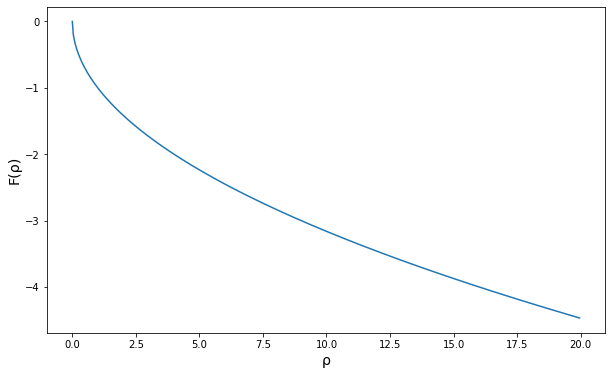

In [30]:
fig = plt.figure(figsize=(10, 6))
plt.plot(builder.rho, builder.F_rho())
plt.xlabel('ρ', size='x-large')
plt.ylabel('F(ρ)', size='x-large')

Text(0, 0.5, 'ρ(r)')

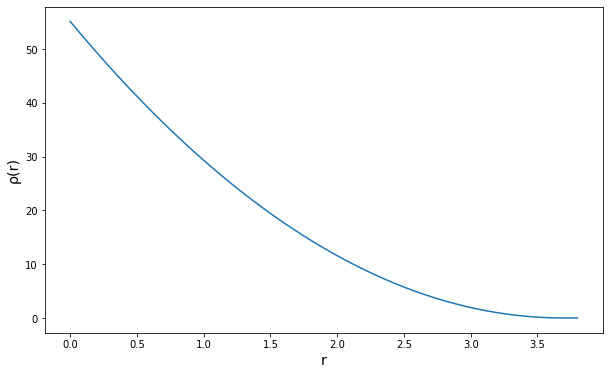

In [31]:
fig = plt.figure(figsize=(10, 6))
plt.plot(builder.r, builder.rho_r())
plt.xlabel('r', size='x-large')
plt.ylabel('ρ(r)', size='x-large')

Text(0, 0.5, 'ϕ(r)')

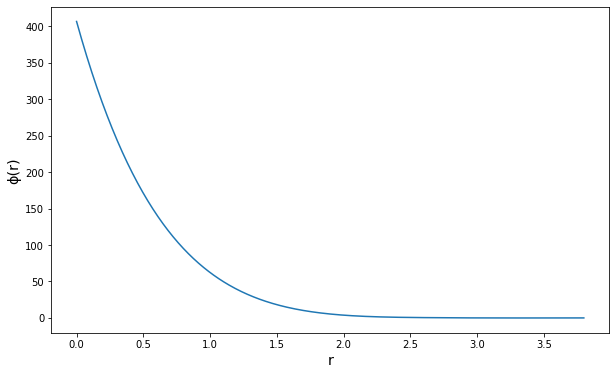

In [32]:
fig = plt.figure(figsize=(10, 6))
plt.plot(builder.r, builder.phi_r())
plt.xlabel('r', size='x-large')
plt.ylabel('ϕ(r)', size='x-large')

## 4. Build parameter file

In [33]:
print(builder.build(ncolumns=4))

This is a demo build for Ackland-Thetford Finnis-Sinclair potentials
NOT TESTED!!!!!
NOTE: max rho and number of tabulation points may affect accuracy!
1 V
500    4.0000000000000001e-02 500    7.6152304609218430e-03    3.7999999999999998e+00
23    5.0941499999999998e+01    3.0299999999999998e+00 bcc
   0.0000000000000000e+00   -2.0000000000000001e-01   -2.8284271247461901e-01   -3.4641016151377546e-01
  -4.0000000000000002e-01   -4.4721359549995793e-01   -4.8989794855663560e-01   -5.2915026221291817e-01
  -5.6568542494923801e-01   -5.9999999999999998e-01   -6.3245553203367588e-01   -6.6332495807107994e-01
  -6.9282032302755092e-01   -7.2111025509279791e-01   -7.4833147735478833e-01   -7.7459666924148340e-01
  -8.0000000000000004e-01   -8.2462112512353214e-01   -8.4852813742385702e-01   -8.7177978870813466e-01
  -8.9442719099991586e-01   -9.1651513899116799e-01   -9.3808315196468595e-01   -9.5916630466254393e-01
  -9.7979589711327120e-01   -1.0000000000000000e+00   -1.0198039027185570e+